<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# Assessment

Congratulations on going through today's course! Hopefully, you've learned some valuable skills along the way and had fun doing it. Now it's time to put those skills to the test. In this assessment, you will train a new model that is able to recognize fresh and rotten fruit. You will need to get the model to a validation accuracy of `92%` in order to pass the assessment, though we challenge you to do even better if you can. You will have the use the skills that you learned in the previous exercises. Specifically, we suggest using some combination of transfer learning, data augmentation, and fine tuning. Once you have trained the model to be at least 92% accurate on the validation dataset, save your model, and then assess its accuracy. Let's get started! 

## The Dataset

In this exercise, you will train a model to recognize fresh and rotten fruits. The dataset comes from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification), a great place to go if you're interested in starting a project after this class. The dataset structure is in the `data/fruits` folder. There are 6 categories of fruits: fresh apples, fresh oranges, fresh bananas, rotten apples, rotten oranges, and rotten bananas. This will mean that your model will require an output layer of 6 neurons to do the categorization successfully. You'll also need to compile the model with `categorical_crossentropy`, as we have more than two categories.

<img src="./images/fruits.png" style="width: 600px;">

## Load ImageNet Base Model

We encourage you to start with a model pretrained on ImageNet. Load the model with the correct weights, set an input shape, and choose to remove the last layers of the model. Remember that images have three dimensions: a height, and width, and a number of channels. Because these pictures are in color, there will be three channels for red, green, and blue. We've filled in the input shape for you. This cannot be changed or the assessment will fail. If you need a reference for setting up the pretrained model, please take a look at [notebook 05b](05b_presidential_doggy_door.ipynb) where we implemented transfer learning.

In [30]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [31]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Freeze Base Model

Next, we suggest freezing the base model, as done in [notebook 05b](05b_presidential_doggy_door.ipynb). This is done so that all the learning from the ImageNet dataset does not get destroyed in the initial training.

In [32]:
# Freeze base model
base_model.trainable = False

## Add Layers to Model

Now it's time to add layers to the pretrained model. [Notebook 05b](05b_presidential_doggy_door.ipynb) can be used as a guide. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.

In [33]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [34]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile Model

Now it's time to compile the model with loss and metrics options. Remember that we're training on a number of different categories, rather than a binary classification problem.

In [35]:
model.compile(loss = 'categorical_crossentropy' , metrics = ['accuracy'])

## Augment the Data

If you'd like, try to augment the data to improve the dataset. Feel free to look at [notebook 04a](04a_asl_augmentation.ipynb) and [notebook 05b](05b_presidential_doggy_door.ipynb) for augmentation examples. There is also documentation for the [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). This step is optional, but it may be helpful to get to 92% accuracy.

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,)
datagen_valid = ImageDataGenerator(samplewise_center=True)

## Load Dataset

Now it's time to load the train and validation datasets. Pick the right folders, as well as the right `target_size` of the images (it needs to match the height and width input of the model you've created). For a reference, check out [notebook 05b](05b_presidential_doggy_door.ipynb).

In [37]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    "data/fruits/train/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    "data/fruits/valid",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)

Found 1182 images belonging to 6 classes.
Found 329 images belonging to 6 classes.


## Train the Model

Time to train the model! Pass the `train` and `valid` iterators into the `fit` function, as well as setting the desired number of epochs.

In [38]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=20)

Epoch 1/20
37/36 [==============================] - 26s 711ms/step - loss: 3.2263 - accuracy: 0.4086 - val_loss: 1.2845 - val_accuracy: 0.6109
Epoch 2/20
37/36 [==============================] - 17s 470ms/step - loss: 0.9199 - accuracy: 0.7166 - val_loss: 0.5107 - val_accuracy: 0.8389
Epoch 3/20
37/36 [==============================] - 17s 462ms/step - loss: 0.4664 - accuracy: 0.8477 - val_loss: 0.4300 - val_accuracy: 0.8693
Epoch 4/20
37/36 [==============================] - 17s 465ms/step - loss: 0.2820 - accuracy: 0.8968 - val_loss: 0.2313 - val_accuracy: 0.9483
Epoch 5/20
37/36 [==============================] - 17s 461ms/step - loss: 0.1848 - accuracy: 0.9416 - val_loss: 0.3112 - val_accuracy: 0.8906
Epoch 6/20
37/36 [==============================] - 17s 461ms/step - loss: 0.1503 - accuracy: 0.9450 - val_loss: 0.2040 - val_accuracy: 0.9392
Epoch 7/20
37/36 [==============================] - 17s 462ms/step - loss: 0.1155 - accuracy: 0.9585 - val_loss: 0.1845 - val_accuracy: 0.9483

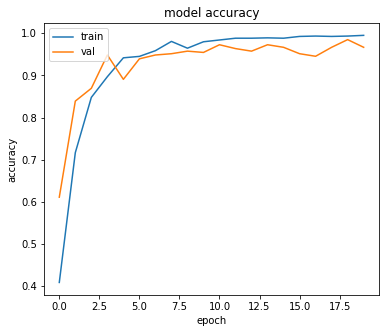

In [39]:
from matplotlib import pyplot as plt
history = model.history
fig, axs = plt.subplots(1,1, figsize=(6, 5))
axs.plot(history.history['accuracy'])
axs.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Unfreeze Model for Fine Tuning

If you have reached 92% validation accuracy already, this next step is optional. If not, we suggest fine tuning the model with a very low learning rate.

In [41]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.00001),
              loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [42]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=20)

Epoch 1/20
37/36 [==============================] - 31s 833ms/step - loss: 0.0568 - accuracy: 0.9797 - val_loss: 0.1026 - val_accuracy: 0.9878
Epoch 2/20
37/36 [==============================] - 18s 493ms/step - loss: 0.0328 - accuracy: 0.9898 - val_loss: 0.1534 - val_accuracy: 0.9696
Epoch 3/20
37/36 [==============================] - 19s 506ms/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.1469 - val_accuracy: 0.9757
Epoch 4/20
37/36 [==============================] - 18s 492ms/step - loss: 0.0209 - accuracy: 0.9907 - val_loss: 0.1246 - val_accuracy: 0.9848
Epoch 5/20
37/36 [==============================] - 18s 487ms/step - loss: 0.0250 - accuracy: 0.9941 - val_loss: 0.1633 - val_accuracy: 0.9696
Epoch 6/20
37/36 [==============================] - 19s 506ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.1391 - val_accuracy: 0.9818
Epoch 7/20
37/36 [==============================] - 18s 493ms/step - loss: 0.0071 - accuracy: 0.9966 - val_loss: 0.1616 - val_accuracy: 0.9696

## Evaluate the Model

Hopefully, you now have a model that has a validation accuracy of 92% or higher. If not, you may want to go back and either run more epochs of training, or adjust your data augmentation. 

Once you are satisfied with the validation accuracy, evaluate the model by executing the following cell. The evaluate function will return a tuple, where the first value is your loss, and the second value is your accuracy. To pass, the model will need have an accuracy value of `92% or higher`. 

In [43]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

11/10 [================================] - 2s 140ms/step - loss: 0.0994 - accuracy: 0.9909


[0.09938199818134308, 0.9908814430236816]

## Run the Assessment

To assess your model run the following two cells.

**NOTE:** `run_assessment` assumes your model is named `model` and your validation data iterator is called `valid_it`. If for any reason you have modified these variable names, please update the names of the arguments passed to `run_assessment`.

In [44]:
from run_assessment import run_assessment

In [45]:
run_assessment(model, valid_it)

Evaluating model 5 times to obtain average accuracy...

11/10 [================================] - 1s 134ms/step - loss: 0.1278 - accuracy: 0.9939

Accuracy required to pass the assessment is 0.92 or greater.
Your average accuracy is 0.9884.

Congratulations! You passed the assessment!
See instructions below to generate a certificate.


## Generate a Certificate

If you passed the assessment, please return to the course page (shown below) and click the "ASSESS TASK" button, which will generate your certificate for the course.

<img src="./images/assess_task.png" style="width: 800px;">

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>